# Day 2 : Contextual Bandits

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Content

- Contextual Bandits
- Epsilon-Greedy Neural
- Bayesian Linear
- Neural Linear
- Exercise

## Contextual Bandits

Let's generate some sample data

In [2]:
from sklearn.datasets import make_blobs
from Day2.util import plot_2d

In [5]:
num_steps = 10000
num_samples = 10*num_steps
X, y = make_blobs(n_samples=num_samples, centers=3, n_features=2, cluster_std=2)

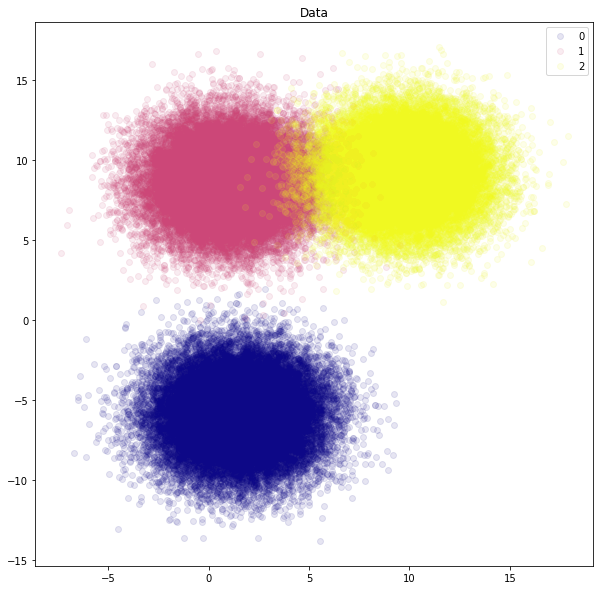

In [6]:
plot_2d(X, y)

Let us load the `ContextualBandit` class.

In [7]:
from Day2.bandits import ContextualBandit

To instantiate a `ContextualBandit`, we need to provide:
- `n`: the number of actions (arms).
- `contexts`: a numpy array where each row corresponds to an observation with the columns as features.
- `rewards`: a numpy array where the rows corresponds to observations (with the same index as `contexts`) and the columns correspond to the actions, each entry corresponds to the reward for each action.  

We already have the array of contexts `X`. We require the array of rewards which we'll create next. We will assume the following:
- Correctly labeling and object of class $0$ has a reward of : $1.0$
- Incorrectly labeling and object of class $0$ has a reward of : $0.0$
- Correctly labeling and object of class $1$ has a reward of : $2.5$
- Incorrectly labeling and object of class $1$ has a reward of : $-1.0$
- Correctly labeling and object of class $2$ has a reward of : $5.0$
- Incorrectly labeling and object of class $2$ has a reward of : $-2.0$

In [8]:
def select_reward(context, predicted_label):
    idx = np.where(X == context)[0][0]
    true_label = y[idx]
    if true_label == 0 & predicted_label == 0:
        reward_vector = [1.0, -1.0, -2.0]
    if true_label == 1 & predicted_label == 1:
        reward_vector = [0.0, 2.5, -2.0]
    if true_label == 2 & predicted_label == 2:
        reward_vector = [0.0, -1.0, 5.0]
    if true_label != predicted_label:
        reward_vector = [0.0, -1.0, -2.0]
    return reward_vector

In [9]:
rewards = np.array([select_reward(X[i], y[i]) for i in range(num_samples)])

Let us instantiate a `ContextualBandit`.

In [10]:
cb = ContextualBandit(3, X, rewards)

A `ContextualBandit` has $4$ methods:
- `generate_context(num=1)`: takes a number `num` (default $1$) and return `num` randomly sampled contexts.
- `generate_reward(context, action)`: takes a pair `context`, `action` and return the reward for the `action` played in `context`.
- `best_action(context)`: takes a `context` and return the best action (in hindsight).
- `best_reward(context)`: takes a `context` and return the reward of the best action. 

Let's see an example:

In [11]:
print('Given context: {x} \n\
With reward vector: {r} \n\
The best action is: {a}'.format(x=X[2], r=rewards[2], a=cb.best_action(X[2])))

Given context: [ 8.89355795 11.01446877] 
With reward vector: [ 0. -1.  5.] 
The best action is: 2


## Epsilon-Greedy Neural 

The first strategy we will implement is `EpsilonGreedyNeural`

In [12]:
import tensorflow as tf
from Day2.util import ContextualDataset
from Day2.solvers import EpsilonGreedyNeural, Random

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


`EpsilonGreedyNeural` is initialized with a `ContextualBandit` object, a value $\epsilon \in [0,1]$ and a Keras compiled neural network.

Below we define and compile such network. The network should have as input shape the number of features of the context and as output shape the number of actions, or arms. The optimizer is `Adam` and the loss is `MeanSquaredError`.

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='linear')
])

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                150       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


We initialize the strategy as well as a random strategy for comparison. The `Random` strategy plays a random arm at each iteration.

In [16]:
epsilon = EpsilonGreedyNeural(cb, 0.1, model)
random = Random(cb)

Let's run the bandits for $10000$ steps. In each iteration, we will obtain a `context`, select an `action` acording to the strategy, observe a `reward` and `update` the strategy.

In [17]:
# Run the EpsilonGreedyNeural strategy
for i in tqdm(range(num_steps)):
    context = cb.generate_context()
    action = epsilon.action(context)
    reward = cb.generate_reward(context, action)
    epsilon.update(context, action, reward)

100%|██████████| 10000/10000 [02:58<00:00, 56.12it/s]


In [18]:
# Run the Random strategy
for i in tqdm(range(num_steps)):
    context = cb.generate_context()
    action = random.action(context)
    reward = cb.generate_reward(context, action)
    random.update(context, action, reward)

100%|██████████| 10000/10000 [02:15<00:00, 74.38it/s]


Now we analize the results. First we compare the cumulative regret.

In [19]:
from Day2.util import plot_regret

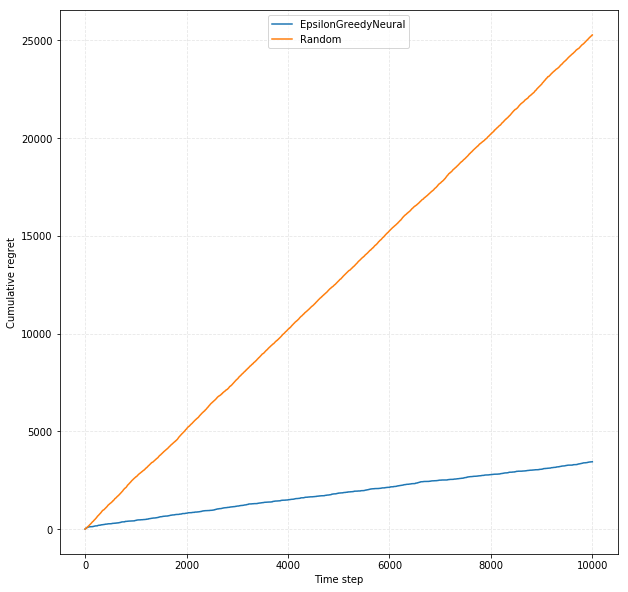

In [20]:
plot_regret([epsilon, random], ['EpsilonGreedyNeural', 'Random'])

We can also visualize the decision boundary of the strategy.

In [21]:
from Day2.util import plot_decision_boundary

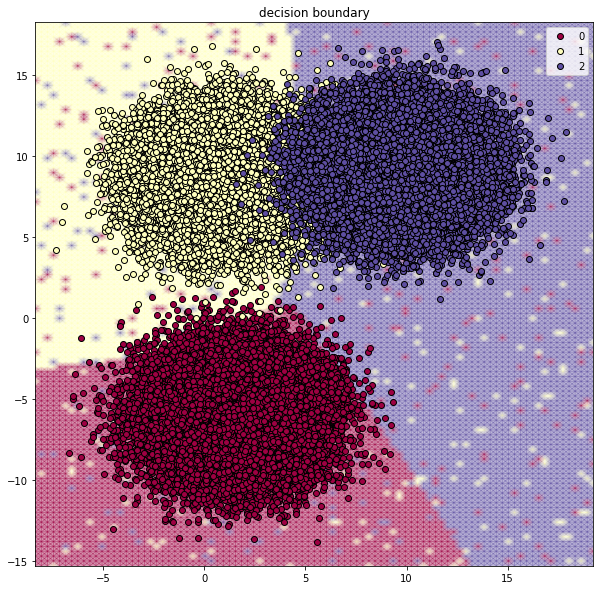

In [22]:
plot_decision_boundary(epsilon, X, y)

Just for fun, let's plot the decision boundary of the `Random` strategy.

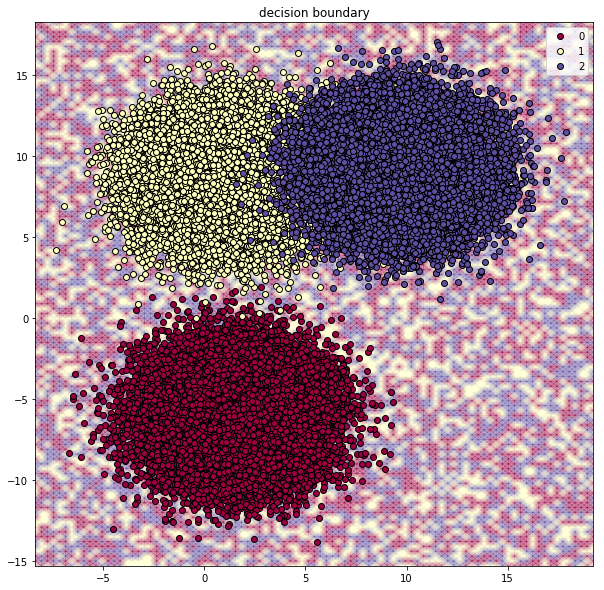

In [23]:
plot_decision_boundary(random, X, y)

## Neural Linear (Bayesian Thompson Sampling)

Finally we analize the `NeuralLinear` strategy.

In [49]:
from Day2.solvers import NeuralLinear

To initialize a `NeuralLinear` object we require a contextual bandit and a pre-compiled Keras neural network.

We utilize the same architecture que used for the `EpsilonGreedyNeural` strategy.

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='linear')
])

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                150       
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 153       
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


We initialize the models.

In [53]:
nlinear = NeuralLinear(cb, model)

And we run the loop for $1000$ rounds.

In [54]:
# Run the NeuralLinear strategy
for i in tqdm(range(num_steps)):
    context = cb.generate_context()
    action = nlinear.action(context)
    reward = cb.generate_reward(context, action)
    nlinear.update(context, action, reward)

100%|██████████| 10000/10000 [12:37<00:00, 15.86it/s] 


We compare the cumulative regret with the `Random` strategy.

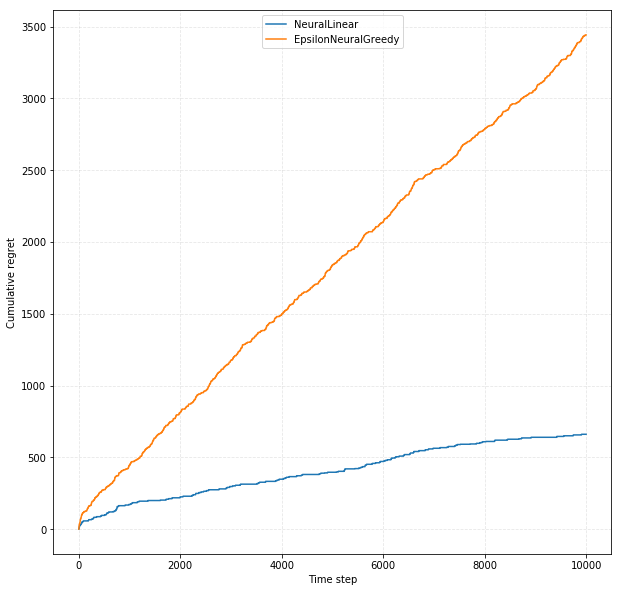

In [55]:
plot_regret([nlinear, epsilon], ['NeuralLinear', 'EpsilonNeuralGreedy'])

And plot the decision boundary.

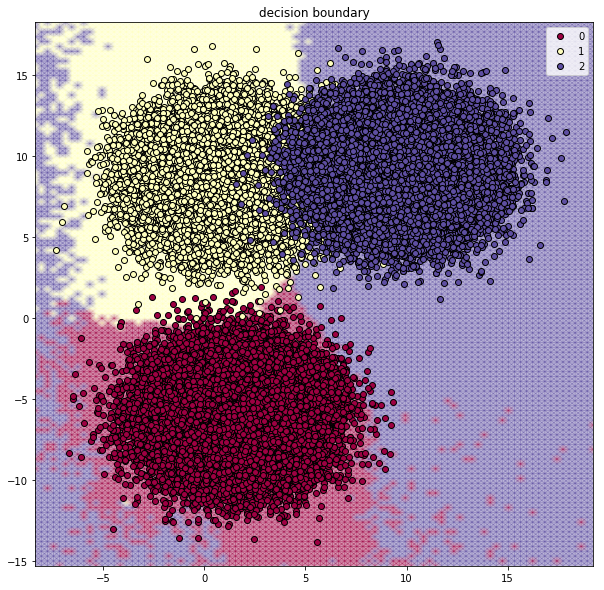

In [58]:
plot_decision_boundary(nlinear, X, y)

## Exercise

Use the tools at your disposal to compare the strategies for the contextual bandits problem.